# 序列模型
使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2,...,1000

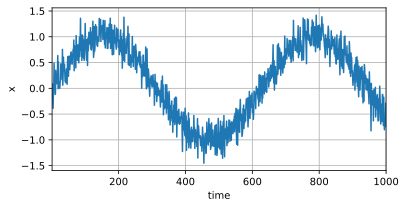

In [3]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) # 加入噪音
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对 $y_t=x_t$ 和 ${X_t} = [{x_{t - \tau }},...,{x_{t - 1}}]$,利用马尔科夫假设思想来使用MLP训练模型。马尔科夫假设是指：随后的事只跟前面$\tau $个时间的事相关，再往前，就认为不相关了！

In [12]:
tau = 4
features = torch.zeros((T - tau, tau)) # T - tau个样本，tau为历史序列长度，这里就是输入的特征
for i in range(tau):
    features[:, i] = x[i:T - tau + i] # 将特征复制过来（一列一列的复制）,这个其实就是滑动窗口的思路，后一个样本在前一个样本的基础上向前一个时间步
labels = x[tau:].reshape((-1, 1)) # 标签从第tau个时间开始

batch_size, n_train = 16, 600 # n_train选择前600个样本
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True) # 把特征和标签组合成迭代器

使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机

In [13]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights) # 初始化权重
    return net

loss = nn.MSELoss()

训练模型

In [17]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.054521
epoch 2, loss: 0.050538
epoch 3, loss: 0.050667
epoch 4, loss: 0.048887
epoch 5, loss: 0.048056
epoch 6, loss: 0.050752
epoch 7, loss: 0.054159
epoch 8, loss: 0.049526
epoch 9, loss: 0.047327
epoch 10, loss: 0.049193


模型预测下一个时间步

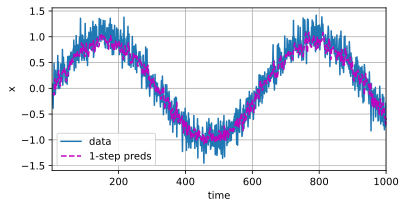

In [32]:
onestep_preds = net(features) # 前面将前600的样本用于训练，这里就把所有的训练和没训练的都放入训练好的mlp中进行预测
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

进行多步预测:用前4个，预测后400个（发现错的离谱）

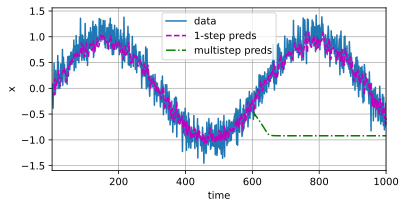

In [38]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau] # 将前604的值，赋值给multistep_preds，后面的需要我们预测
for i in range(n_train + tau, T): # 从604到1000
    # 这个就是从600开始预测：用600-604预测605，然后用601-605预测606，一直这样。发现预测结果差的很多（绿色线），因为这样预测，误差会累积。
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1))) 

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

更仔细地看一下$k$步预测：用前4个预测后$k$个，发现随着$k$的增加，预测效果越来越差，这个很正常

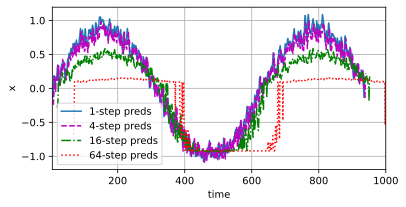

In [41]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

# 这里我需要说下：多步预测，是这样的：比如我用前4个预测后4个，那操作就是，先用前4个，预测第5个，然后把预测的5加入（不用真实的5，不然就成单步预测了），用2-5这四个，预测第6个，依次类推。。。